In [1]:
import time
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import uniform, randint
from rdkit import Chem
from rdkit.Chem import Draw

from sklearn.preprocessing import OneHotEncoder,StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import PredictionErrorDisplay as PED
from sklearn.metrics import r2_score,mean_absolute_error, mean_squared_error,root_mean_squared_error
from sklearn.model_selection import cross_val_score,train_test_split, KFold,RandomizedSearchCV,GridSearchCV
import pickle
from joblib import dump, load

In [2]:
X=pd.read_pickle("data/processed/calc_descriptors_final.pkl")
print("n_features: ", len(X.columns))

print(X['Ipc'].max(),X['Ipc'].min())
scaler = MinMaxScaler()
X['Ipc'] = scaler.fit_transform(X['Ipc'].values.reshape(-1,1))
print(X['Ipc'].max(),X['Ipc'].min())


scaler=StandardScaler().fit(X)
scaled=scaler.transform(X)

df=pd.read_pickle("data/processed/gap_smile.pkl")
y=df["GAP"].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(scaled,y,test_size=0.3,random_state=42)

n_features:  56
219.2769658075064 1.0851048673387407
1.0 0.0


In [3]:
load_file='data/processed/reg_NN_MLP.joblib'
reg=load(load_file)

/home/sat/miniforge3/envs/py310hl_gaps_pub/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MLPRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [4]:
#predict all 
gap_pred=reg.predict(scaled)
print(len(gap_pred))

406203


In [5]:
df["GAP_P"]=gap_pred

In [6]:
def get_metrics(df,pred,test):
    #print(df)
    y_pred=df[pred]
    y_test=df[test]
    r2=r2_score(y_pred=y_pred,y_true=y_test)
    mse=mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    
    return r2,mse,mae,rmse

In [7]:
#prediction on trained molecules

y_pred_train=reg.predict(X_train)

mse = mean_squared_error(y_train, y_pred_train)
print("The mean squared error (MSE)  on test set: {:.4f}".format(mse))
rmse = root_mean_squared_error(y_train, y_pred_train)
print("The mean squared error (RMSE) on test set: {:.4f}".format(rmse))
mae = mean_absolute_error(y_train, y_pred_train)
print("The mean squared error (MAE)  on test set: {:.4f}".format(mae))

print("R2-score:",r2_score(y_pred=y_pred_train,y_true=y_train))

The mean squared error (MSE)  on test set: 0.0551
The mean squared error (RMSE) on test set: 0.2347
The mean squared error (MAE)  on test set: 0.1733
R2-score: 0.966901489235207


In [8]:
#prediction on untrained/test molecules

y_pred=reg.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("The mean squared error (MSE)  on test set: {:.4f}".format(mse))
rmse = root_mean_squared_error(y_test, y_pred)
print("The mean squared error (RMSE) on test set: {:.4f}".format(rmse))
mae = mean_absolute_error(y_test, y_pred)
print("The mean squared error (MAE)  on test set: {:.4f}".format(mae))

print("R2-score:",r2_score(y_pred=y_pred,y_true=y_test))

The mean squared error (MSE)  on test set: 0.0907
The mean squared error (RMSE) on test set: 0.3012
The mean squared error (MAE)  on test set: 0.2121
R2-score: 0.9455896445822082


In [9]:
df_concat=pd.concat([df,X],axis=1,join='inner')
df_concat

/home/sat/miniforge3/envs/py310hl_gaps_pub/lib/python3.10/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/home/sat/miniforge3/envs/py310hl_gaps_pub/lib/python3.10/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,GAP,SMILE,GAP_P,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,SPS,MolWt,NumRadicalElectrons,AvgIpc,...,fr_NH0,fr_NH2,fr_allylic_oxid,fr_aniline,fr_aryl_methyl,fr_bicyclic,fr_ester,fr_ketone,fr_para_hydroxylation,fr_piperdine
0,4.218750,CC(=C)C1C2OC(=O)C1C1(O)CC3OC33C(=O)OC2C13C,3.887645,13.421670,1.813652,-4.213449,93.904762,292.287,0,3.203010,...,0,0,0,0,0,4,2,0,0,0
1,1.830078,O=C(O)C=1C(=O)C(O)(CC(=O)C1N)C2OC(COC(=O)C)C(O...,1.460255,14.938999,0.626931,-6.373747,66.444444,660.651,0,3.295038,...,1,1,2,0,0,0,2,2,0,0
2,1.650391,O=C1OC2C(O)C=CC3C4=C5C(=O)C=6C(OC)=CC=C(OC)C6C...,1.858951,15.674552,1.517576,-4.913705,45.409091,598.604,0,3.352137,...,0,0,1,0,0,6,1,2,0,0
3,1.730469,O=C1OC2C(O)C=CC3C4=C5C(=O)C=6C=CC=C(O)C6C(=O)C...,1.732663,15.162100,1.184590,-4.773941,45.804878,554.551,0,3.323824,...,0,0,1,0,0,6,1,2,0,0
4,3.580078,O=C(OC1CC(C)(CCOC(=O)C(C)(C)C)C2CC(C)(C)CC2C1O...,3.363940,14.690159,1.393863,-6.473465,57.538462,534.693,0,3.304427,...,0,0,0,0,0,1,3,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406198,3.970703,O=C(NCCN=C(O)C(F)(F)C(F)(F)C(F)(F)F)C(F)(F)C(F...,3.877003,13.510691,1.513305,-7.333639,19.571429,452.142,0,2.615850,...,1,0,0,0,0,0,0,0,0,0
406199,1.429688,O=C(O)C=CC1=C2NC(C=C3N=C(C=C4NC(=CC5=NC=6C(C(=...,1.545973,15.059651,0.354457,-4.267296,30.500000,588.664,0,4.039629,...,2,0,5,0,3,8,1,1,0,0
406200,3.130859,O[C]1[CH][C](O)[C]2[CH][C](OC3OC(CO)C(O)C(O)C3...,2.474674,9.735870,0.859880,-5.445191,72.090909,626.564,15,3.337697,...,0,0,0,0,0,1,0,0,0,0
406201,1.839844,O=C(N)C1C(=O)C(N(C)C)C2CC3CC4=C(C(=O)C3C(=O)C2...,1.500383,15.164901,0.812307,-5.526028,60.818182,457.483,0,3.064037,...,2,1,0,1,0,3,0,4,0,0


In [10]:
df_concat['diff']=df_concat['GAP']-df_concat['GAP_P']
df_concat

/home/sat/miniforge3/envs/py310hl_gaps_pub/lib/python3.10/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/home/sat/miniforge3/envs/py310hl_gaps_pub/lib/python3.10/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,GAP,SMILE,GAP_P,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,SPS,MolWt,NumRadicalElectrons,AvgIpc,...,fr_NH2,fr_allylic_oxid,fr_aniline,fr_aryl_methyl,fr_bicyclic,fr_ester,fr_ketone,fr_para_hydroxylation,fr_piperdine,diff
0,4.218750,CC(=C)C1C2OC(=O)C1C1(O)CC3OC33C(=O)OC2C13C,3.887645,13.421670,1.813652,-4.213449,93.904762,292.287,0,3.203010,...,0,0,0,0,4,2,0,0,0,0.331105
1,1.830078,O=C(O)C=1C(=O)C(O)(CC(=O)C1N)C2OC(COC(=O)C)C(O...,1.460255,14.938999,0.626931,-6.373747,66.444444,660.651,0,3.295038,...,1,2,0,0,0,2,2,0,0,0.369824
2,1.650391,O=C1OC2C(O)C=CC3C4=C5C(=O)C=6C(OC)=CC=C(OC)C6C...,1.858951,15.674552,1.517576,-4.913705,45.409091,598.604,0,3.352137,...,0,1,0,0,6,1,2,0,0,-0.208561
3,1.730469,O=C1OC2C(O)C=CC3C4=C5C(=O)C=6C=CC=C(O)C6C(=O)C...,1.732663,15.162100,1.184590,-4.773941,45.804878,554.551,0,3.323824,...,0,1,0,0,6,1,2,0,0,-0.002194
4,3.580078,O=C(OC1CC(C)(CCOC(=O)C(C)(C)C)C2CC(C)(C)CC2C1O...,3.363940,14.690159,1.393863,-6.473465,57.538462,534.693,0,3.304427,...,0,0,0,0,1,3,0,0,0,0.216138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406198,3.970703,O=C(NCCN=C(O)C(F)(F)C(F)(F)C(F)(F)F)C(F)(F)C(F...,3.877003,13.510691,1.513305,-7.333639,19.571429,452.142,0,2.615850,...,0,0,0,0,0,0,0,0,0,0.093700
406199,1.429688,O=C(O)C=CC1=C2NC(C=C3N=C(C=C4NC(=CC5=NC=6C(C(=...,1.545973,15.059651,0.354457,-4.267296,30.500000,588.664,0,4.039629,...,0,5,0,3,8,1,1,0,0,-0.116286
406200,3.130859,O[C]1[CH][C](O)[C]2[CH][C](OC3OC(CO)C(O)C(O)C3...,2.474674,9.735870,0.859880,-5.445191,72.090909,626.564,15,3.337697,...,0,0,0,0,1,0,0,0,0,0.656186
406201,1.839844,O=C(N)C1C(=O)C(N(C)C)C2CC3CC4=C(C(=O)C3C(=O)C2...,1.500383,15.164901,0.812307,-5.526028,60.818182,457.483,0,3.064037,...,1,0,1,0,3,0,4,0,0,0.339461


In [11]:
r2,mse,mae,rmse=get_metrics(df_concat,"GAP_P","GAP")
r2,mse,mae,rmse

(0.9605007179840162,
 0.06578637565551436,
 0.18494332273434758,
 0.2564885487804755)

In [12]:
#metrics for subsets of descriptors
results = []
for descr in df_concat.columns:
    if any(sub in descr for sub in ["Num", "fr"]) : #
        df_tmp= df_concat[df_concat[descr]>0]
        #print(descr,type(descr), len(df_tmp))
        r2,mse,mae,rmse=get_metrics(df_tmp,"GAP_P","GAP")
        #print(r2,mse,mae,rmse)
        results.append({
            "descriptor": descr,
            "R2": r2,
            "MSE": mse,
            "MAE": mae,
            "RMSE": rmse,
        })

In [13]:
metrics_df = pd.DataFrame(results)
metrics_df.sort_values(by="R2",ascending=False)
metrics_df.style.format({"R2": "{:.3f}", "MSE": "{:.3f}", "MaE": "{:.3f}", "RMSE": "{:.3f}"})

,descriptor,R2,MSE,MAE,RMSE
0,NumRadicalElectrons,0.506,0.319,0.434290,0.565
1,NumAliphaticHeterocycles,0.954,0.068,0.190391,0.262
2,NumAromaticCarbocycles,0.896,0.054,0.169880,0.231
3,NumAromaticHeterocycles,0.868,0.051,0.166263,0.227
4,fr_Al_COO,0.888,0.070,0.192385,0.265
5,fr_Al_OH_noTert,0.852,0.101,0.229123,0.318
6,fr_Ar_N,0.860,0.060,0.180439,0.245
7,fr_NH0,0.914,0.072,0.193936,0.268
8,fr_NH2,0.936,0.104,0.225950,0.322
9,fr_allylic_oxid,0.934,0.068,0.189421,0.260


In [14]:
# split dataset at 6 eV
df_smaller6eV=df_concat[df_concat['GAP']<6]
df_largereq6eV=df_concat[df_concat['GAP']>=6]
print(len(df_smaller6eV), len(df_largereq6eV))
results=[]
for ds,name in zip([df_smaller6eV,df_largereq6eV,df_concat],["<6eV",">6eV","all"]):
    r2,mse,mae,rmse=get_metrics(ds,"GAP_P","GAP")
    count=len(ds)
    results.append({
    "name":name,
    "count": count,
    "R2": r2,
    "MSE": mse,
    "MAE": mae,
    "RMSE": rmse})
    
df_6ev_split = pd.DataFrame(results)
df_6ev_split.style.format({"name": "{}","count": "{}","R2": "{:.3f}", "MSE": "{:.3f}", "MaE": "{:.3f}", "RMSE": "{:.3f}"})

398003 8200


,name,count,R2,MSE,MAE,RMSE
0,<6eV,398003,0.917,0.064,0.183463,0.254
1,>6eV,8200,0.934,0.135,0.256791,0.368
2,all,406203,0.961,0.066,0.184943,0.256


### SMR analysis

In [15]:
sel=df_concat[["SMR_VSA3","SMR_VSA4","SMR_VSA6","SMR_VSA7","SMR_VSA9","SMR_VSA10"]]
sel

,SMR_VSA3,SMR_VSA4,SMR_VSA6,SMR_VSA7,SMR_VSA9,SMR_VSA10
0,0.000000,17.202906,0.000000,12.104143,0.000000,11.938611
1,0.000000,10.712122,13.596938,23.019255,0.000000,47.529786
2,0.000000,5.414990,28.151810,92.387300,22.998047,17.535795
3,0.000000,5.414990,14.075905,98.429719,17.248535,17.535795
4,0.000000,28.032887,6.558985,71.551090,0.000000,17.907916
...,...,...,...,...,...,...
406198,5.309813,4.992405,12.993719,0.000000,0.000000,11.804925
406199,19.921964,0.000000,7.037952,87.355408,0.000000,68.133148
406200,0.000000,0.000000,27.193875,92.651910,0.000000,0.000000
406201,4.899910,29.295548,32.803217,23.211740,5.749512,34.727546


### fragment distributions

In [16]:
def detect_outliers(df, column, method='iqr', threshold=1.5):
    """
    Detects outliers in a given column of a DataFrame.

    Args:
        df (pandas.DataFrame): The DataFrame containing the data.
        column (str): The name of the column to check for outliers.
        method (str): The method to use for outlier detection. 
                      Options: 'iqr' (Interquartile Range), 'std' (Standard Deviation).
                      Default: 'iqr'.
        threshold (float): The threshold for outlier detection. 
                           For 'iqr' method, it's the number of IQRs to consider as outliers.
                           For 'std' method, it's the number of standard deviations.
                           Default: 1.5.

    Returns:
        pandas.Series: A boolean Series indicating whether each row is an outlier.
    """

    if method == 'iqr':
        # Calculate the first and third quartiles
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)

        # Calculate the Interquartile Range (IQR)
        IQR = Q3 - Q1

        # Define lower and upper bounds for outliers
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR

    elif method == 'std':
        # Calculate the mean and standard deviation
        mean = df[column].mean()
        std_dev = df[column].std()

        # Define lower and upper bounds for outliers
        lower_bound = mean - threshold * std_dev
        upper_bound = mean + threshold * std_dev

    else:
        raise ValueError("Invalid method. Choose 'iqr' or 'std'.")

    # Identify outliers
    return (df[column] < lower_bound) | (df[column] > upper_bound)


In [17]:
count_feat=[any(sub in descr for sub in ["Num", "fr"]) for descr in df_concat.columns].count(True)
print(count_feat/4,int(count_feat/4))
(list(range(count_feat)))
count_feat

4.25 4


17

0 NumAliphaticHeterocycles <class 'str'> 135257 outliers:  4758 ( 3.517747695128533  %)
0.9580091255469352 0.07099315995595165 0.19481883293448443 0.26644541646639686
1 NumAromaticCarbocycles <class 'str'> 140225 outliers:  5142 ( 3.6669638081654483  %)
0.8900448947917627 0.04912840522137272 0.16272597491924623 0.22164928427895433
2 NumAromaticHeterocycles <class 'str'> 38036 outliers:  1233 ( 3.2416657903039225  %)
0.8232757547973331 0.05883370821182659 0.17938999691361612 0.24255660826253855
3 fr_Al_COO <class 'str'> 5983 outliers:  186 ( 3.1088082901554404  %)
0.8525822743641875 0.09404068449633671 0.2229405111315235 0.3066605362552161
4 fr_Al_OH_noTert <class 'str'> 3891 outliers:  206 ( 5.294268825494731  %)
0.7667171549139074 0.1579909400695536 0.29004086729425876 0.39748074175933806
5 fr_Ar_N <class 'str'> 42499 outliers:  1417 ( 3.3341960987317347  %)
0.8475885882985028 0.06892094502050308 0.19363552036630266 0.2625279890230813
6 fr_NH0 <class 'str'> 78393 outliers:  2763 ( 3.5

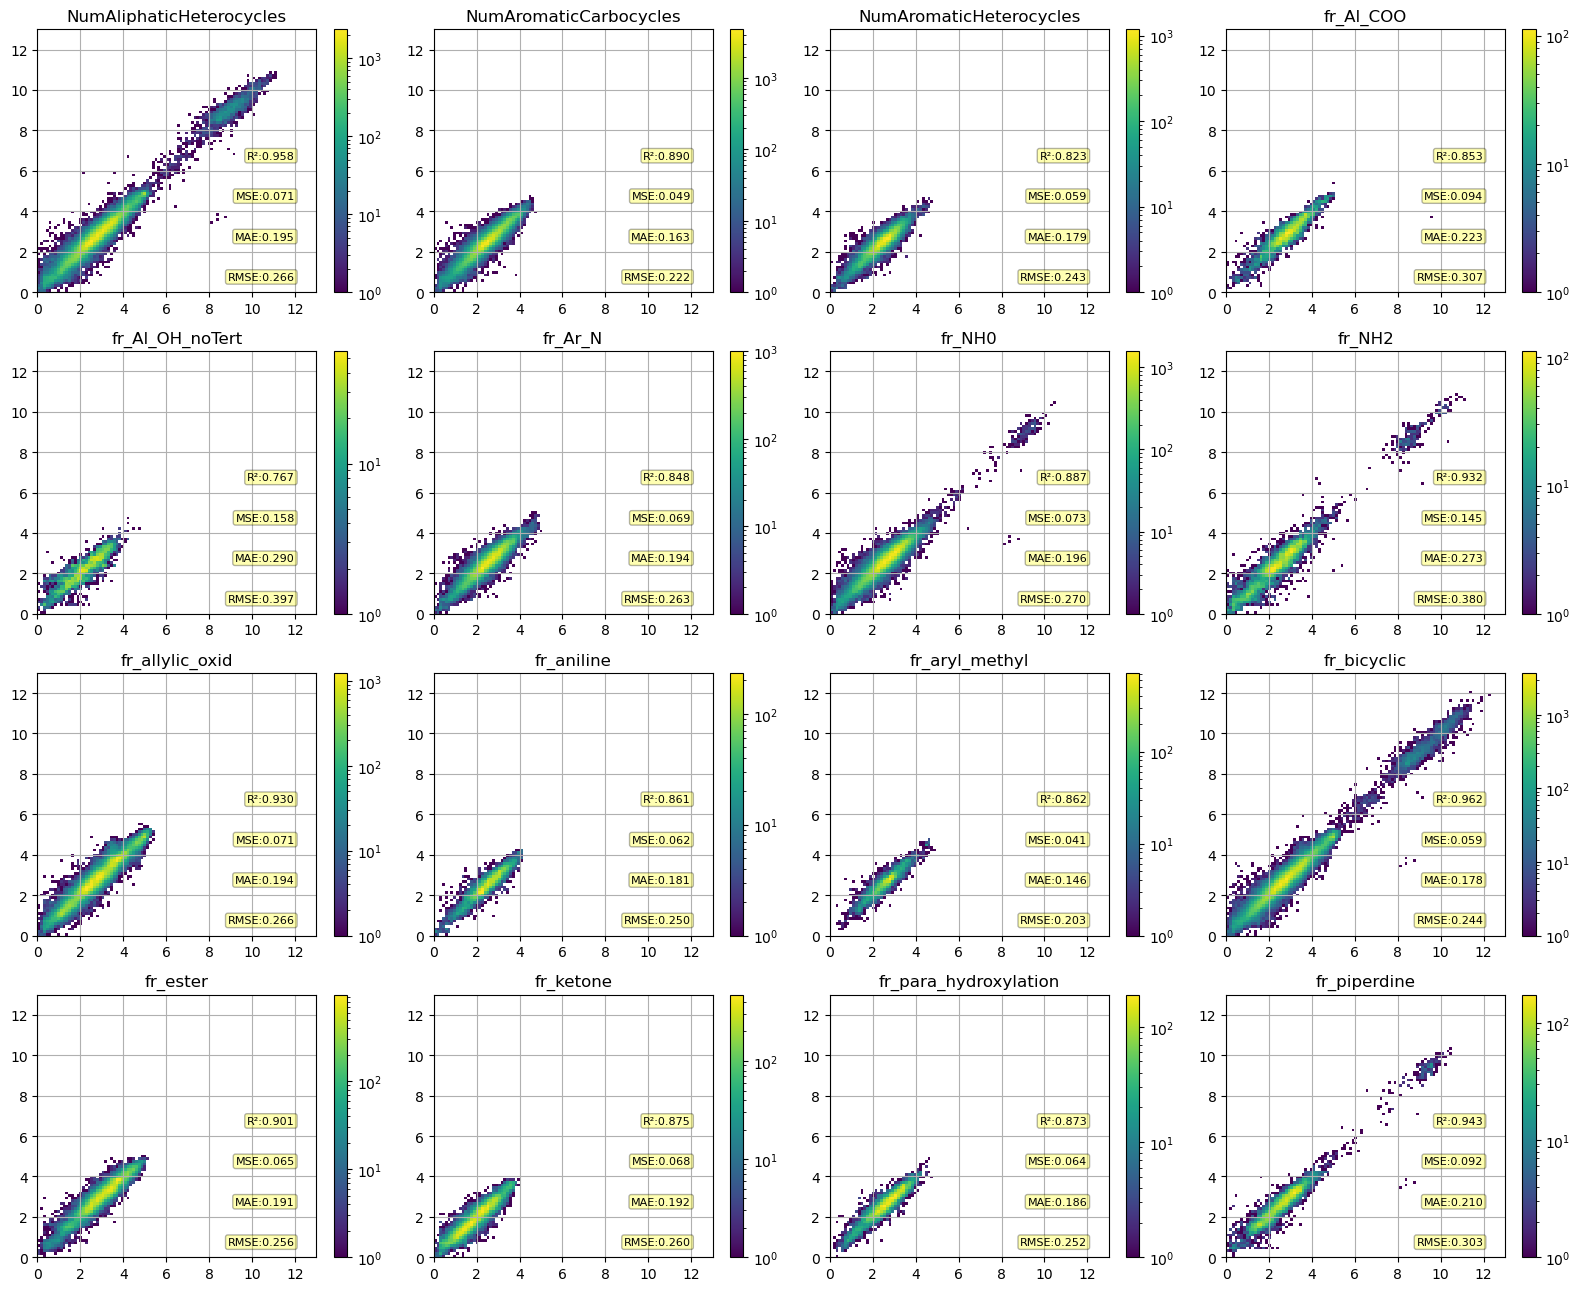

In [18]:
fig, axs = plt.subplots(math.ceil(count_feat/4),4, figsize=(16, 16))
#fig, axs = plt.subplots(math.ceil(count_feat/2),2, figsize=(12, 24))
axs = axs.ravel()
results=[]
num=0
for descr in df_concat.columns:
    if any(sub in descr for sub in ["Num","fr"]) and "NumRadicalElectrons" not in descr: #"Num", "fr"
        df_tmp= df_concat[df_concat[descr]>1]
        outliers = detect_outliers(df_tmp, "diff")
        num_outliers=len(outliers[outliers==True])
        print(num,descr,type(descr), len(df_tmp), "outliers: ",num_outliers,'(',100*len(outliers[outliers==True])/len(outliers)," %)")
        # Generate new heatmap for the column
        x = df_tmp['GAP']
        y = df_tmp['GAP_P']
        heatmap, xedges, yedges = np.histogram2d(x, y, bins=100, range=[[0,13],[0,13]],density=False)
        vmin = heatmap[heatmap > 0].min()
        vmax = heatmap.max()
        im = axs[num].pcolormesh(xedges, yedges, heatmap.T, cmap='viridis', shading='auto',norm=LogNorm(vmin=vmin, vmax=vmax))
        fig.colorbar(im, ax=axs[num]) #), label='number of molecules',)
        r2,mse,mae,rmse=get_metrics(df_tmp,"GAP_P","GAP")
        print(r2,mse,mae,rmse)
        results.append({
            "descriptor": descr,
            "R2": r2,
            "MSE": mse,
            "MAE": mae,
            "RMSE": rmse,
        })
        axs[num].set_title(f"{descr}")
        #axs[num].set_xlabel("GAP_P [eV]")
        #axs[num].set_ylabel("GAP [eV]")
        axs[num].text(
            12,  # x-coordinate of the text
            6.5,  # y-coordinate of the text
            f"R²:{r2:.3f}",  # The text string
            fontsize=8,  # Font size
            color='k',  # Text color
            ha='right',  # Horizontal alignment ('left', 'center', 'right')
            va='bottom',  # Vertical alignment ('top', 'center', 'bottom', 'baseline')
            bbox=dict(facecolor='yellow', alpha=0.3, edgecolor='black', boxstyle='round,pad=0.2') # Add a background box
        )
        axs[num].text(
            12,  # x-coordinate of the text
            4.5,  # y-coordinate of the text
            f"MSE:{mse:.3f}",  # The text string
            fontsize=8,  # Font size
            color='k',  # Text color
            ha='right',  # Horizontal alignment ('left', 'center', 'right')
            va='bottom',  # Vertical alignment ('top', 'center', 'bottom', 'baseline')
            bbox=dict(facecolor='yellow', alpha=0.3, edgecolor='black', boxstyle='round,pad=0.2') # Add a background box
        )
        axs[num].text(
            12,  # x-coordinate of the text
            2.5,  # y-coordinate of the text
            f"MAE:{mae:.3f}",  # The text string
            fontsize=8,  # Font size
            color='k',  # Text color
            ha='right',  # Horizontal alignment ('left', 'center', 'right')
            va='bottom',  # Vertical alignment ('top', 'center', 'bottom', 'baseline')
            bbox=dict(facecolor='yellow', alpha=0.3, edgecolor='black', boxstyle='round,pad=0.2') # Add a background box
        )
        axs[num].text(
            12,  # x-coordinate of the text
            0.5,  # y-coordinate of the text
            f"RMSE:{rmse:.3f}",  # The text string
            fontsize=8,  # Font size
            color='k',  # Text color
            ha='right',  # Horizontal alignment ('left', 'center', 'right')
            va='bottom',  # Vertical alignment ('top', 'center', 'bottom', 'baseline')
            bbox=dict(facecolor='yellow', alpha=0.3, edgecolor='black', boxstyle='round,pad=0.2') # Add a background box
        )
        axs[num].set_xticks([0,2,4,6,8,10,12])
        axs[num].set_yticks([0,2,4,6,8,10,12])
        axs[num].set_xlim(0, 13)
        axs[num].set_ylim(0, 13)
        axs[num].grid()
        #fig.colorbar(im, ax=axs[num], label="Counts")
        #break  # Remove this if you want to create more subplots for other columns
        num+=1
# Hide any unused subplots
for j in range(num, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.savefig("feature_distribution_4x4.png")
plt.show()

In [19]:
metrics_df = pd.DataFrame(results)
metrics_df.sort_values(by="R2",ascending=False)
metrics_df.style.format({"R2": "{:.3f}", "MSE": "{:.3f}", "MAE": "{:.3f}", "RMSE": "{:.3f}"})

,descriptor,R2,MSE,MAE,RMSE
0,NumAliphaticHeterocycles,0.958,0.071,0.195,0.266
1,NumAromaticCarbocycles,0.890,0.049,0.163,0.222
2,NumAromaticHeterocycles,0.823,0.059,0.179,0.243
3,fr_Al_COO,0.853,0.094,0.223,0.307
4,fr_Al_OH_noTert,0.767,0.158,0.290,0.397
5,fr_Ar_N,0.848,0.069,0.194,0.263
6,fr_NH0,0.887,0.073,0.196,0.270
7,fr_NH2,0.932,0.145,0.273,0.380
8,fr_allylic_oxid,0.930,0.071,0.194,0.266
9,fr_aniline,0.861,0.062,0.181,0.250


### IQR vs Outliers

In [20]:
def count_occurrences_in_symmetric_ranges_summarized(df, column_name, range_endpoints):
    """
    Calculates the number of occurrences within symmetrically generated ranges 
    around 0 in a DataFrame column, summarizing symmetric ranges and excluding (0,0).

    Args:
        df (pd.DataFrame): The input DataFrame.
        column_name (str): The name of the column to analyze.
        range_endpoints (list of float): A list of *positive* range endpoints. 
                                          Must be sorted in ascending order.

    Returns:
        dict: A dictionary where keys are the *positive* range endpoints (float)
              and values are the *sum* of counts for the corresponding 
              symmetric ranges. Returns an empty dictionary if the column
              does not exist.
    """

    if column_name not in df.columns:
        print(f"Column '{column_name}' not found in DataFrame.")
        return {}

    counts = {}
    previous_endpoint = 0  # Start with 0 as the initial lower bound

    for endpoint in range_endpoints:
        if endpoint != 0:  # Exclude (0,0) equivalent
            lower_bound_neg = -endpoint
            upper_bound_neg = -previous_endpoint  # Use the PREVIOUS endpoint as the upper bound for the negative range
            lower_bound_pos = previous_endpoint # Use the PREVIOUS endpoint as the lower bound for the positive range
            upper_bound_pos = endpoint

            count_neg = df[column_name].between(lower_bound_neg, upper_bound_neg, inclusive='both').sum()
            count_pos = df[column_name].between(lower_bound_pos, upper_bound_pos, inclusive='both').sum()
            total_count = count_neg + count_pos

            percentage = total_count / len(df) * 100 #if total_non_zero > 0 else 0  # Avoid division by zero

            counts[(lower_bound_pos, upper_bound_pos)] = {
                'count': total_count,
                'percentage': percentage
            }

        previous_endpoint = endpoint  # Update previous endpoint for the next iteration

    return counts

In [21]:

results={}
results_tot={}
results_abs={}
gap_ranges=[0.0, 0.1, 0.2, 0.4, 0.8, 1.2, 2.0, 10.0] #[(-10.0,-5.0),(-5.0,-2.0),(-2.0,-1.0),(-1.0,-0.5),(-0.5,-0.2),(-0.2,0.0),(0.0,0.2),(0.2,0.5),(0.5,1.0),(1.0,2.0),(2.0,5.0),(5.0,10.0)]
iqr_range=np.arange(0.0,10.2,1.0)
iqr_range=np.array([0.0,0.5,1.0,1.5,2.0,3.0,4.0,6.0,8.0,10.0])
results["threshold"]=iqr_range
results_tot["threshold"]=iqr_range
num=0
for descr in df_concat.columns:
    if any(sub in descr for sub in ["Num","fr"]) and "NumRadicalElectrons" not in descr: #"Num", "fr"
        df_tmp= df_concat[df_concat[descr]>1]
        print(num,descr,type(descr), len(df_tmp))
        iqr_percentage=[]
        iqr_tot=[]
        for thr in iqr_range:
            outliers = detect_outliers(df_tmp, "diff", threshold=thr)
            num_outliers=len(outliers[outliers==True])
            percentage_outliers=100*len(outliers[outliers==True])/len(outliers)
            print("    threshold:",thr,"    outliers: ",num_outliers,'(',percentage_outliers," %)")
            iqr_percentage.append(percentage_outliers)
            iqr_tot.append(num_outliers)
        outliers_abs= count_occurrences_in_symmetric_ranges_summarized(df_tmp,"diff",gap_ranges)
        results[descr]=iqr_percentage
        results_tot[descr]=iqr_tot
        results_abs[descr]=outliers_abs
#results_abs

0 NumAliphaticHeterocycles <class 'str'> 135257
    threshold: 0.0     outliers:  67628 ( 49.999630333365374  %)
    threshold: 0.5     outliers:  28508 ( 21.076912840000887  %)
    threshold: 1.0     outliers:  11545 ( 8.535602593581109  %)
    threshold: 1.5     outliers:  4758 ( 3.517747695128533  %)
    threshold: 2.0     outliers:  2134 ( 1.5777371965961096  %)
    threshold: 3.0     outliers:  591 ( 0.43694596213134995  %)
    threshold: 4.0     outliers:  180 ( 0.133079988466401  %)
    threshold: 6.0     outliers:  33 ( 0.02439799788550685  %)
    threshold: 8.0     outliers:  8 ( 0.005914666154062266  %)
    threshold: 10.0     outliers:  5 ( 0.0036966663462889167  %)
0 NumAromaticCarbocycles <class 'str'> 140225
    threshold: 0.0     outliers:  70112 ( 49.99964343020146  %)
    threshold: 0.5     outliers:  29778 ( 21.23587092173293  %)
    threshold: 1.0     outliers:  12221 ( 8.715279015867356  %)
    threshold: 1.5     outliers:  5142 ( 3.6669638081654483  %)
    threshol

In [22]:
iqr_df_tot=pd.DataFrame.from_dict(results_tot)
iqr_df=pd.DataFrame.from_dict(results)
iqr_df

,threshold,NumAliphaticHeterocycles,NumAromaticCarbocycles,NumAromaticHeterocycles,fr_Al_COO,fr_Al_OH_noTert,fr_Ar_N,fr_NH0,fr_NH2,fr_allylic_oxid,fr_aniline,fr_aryl_methyl,fr_bicyclic,fr_ester,fr_ketone,fr_para_hydroxylation,fr_piperdine
0,0.0,49.999630,49.999643,50.000000,50.008357,50.012850,50.001176,49.999362,50.005657,50.000580,50.012180,50.000000,49.999721,49.998932,50.000000,50.005349,50.005495
1,0.5,21.076913,21.235871,20.759281,20.457964,24.286816,20.739312,20.980190,21.020477,21.150343,20.828258,22.226578,21.259052,20.225559,21.160938,20.637638,20.639631
2,1.0,8.535603,8.715279,7.895152,8.256727,11.436649,8.155486,8.362992,8.937663,8.859056,8.331303,9.907879,8.677449,7.614755,8.648031,7.852787,7.978899
3,1.5,3.517748,3.666964,3.241666,3.108808,5.294269,3.334196,3.524549,4.378323,3.840665,3.568819,4.596237,3.635441,2.889976,3.853813,3.263079,3.417958
4,2.0,1.577737,1.610269,1.461773,1.153268,2.570033,1.543566,1.695304,2.387148,1.818224,1.619976,2.126617,1.610053,1.226050,1.670600,1.455012,1.769425
5,3.0,0.436946,0.390087,0.370701,0.317566,0.359805,0.392950,0.477083,0.644869,0.489656,0.633374,0.578205,0.429831,0.271269,0.390913,0.417246,0.604462
6,4.0,0.133080,0.121234,0.102534,0.066856,0.051401,0.117650,0.139043,0.203643,0.121834,0.267966,0.196002,0.141604,0.053399,0.077445,0.117685,0.208814
7,6.0,0.024398,0.022820,0.005258,0.016714,0.000000,0.009412,0.026788,0.056567,0.008122,0.036541,0.039200,0.021185,0.004272,0.000000,0.010699,0.109902
8,8.0,0.005915,0.003566,0.000000,0.016714,0.000000,0.000000,0.006378,0.000000,0.002321,0.000000,0.009800,0.007247,0.002136,0.000000,0.000000,0.043961
9,10.0,0.003697,0.001426,0.000000,0.016714,0.000000,0.000000,0.005102,0.000000,0.000000,0.000000,0.000000,0.003902,0.000000,0.000000,0.000000,0.043961


In [23]:
def separate_counts_and_percentages(data_dict):
    """
    Separates a dictionary with tuple keys and dictionaries as values 
    (containing 'count' and 'percentage') into two DataFrames.

    Args:
        data_dict (dict): The input dictionary.

    Returns:
        tuple: A tuple containing two pandas DataFrames: 
               (counts_df, percentages_df).
               Returns (None, None) if the input is not in the expected format 
               or if the input dictionary is empty.
    """

    if not isinstance(data_dict, dict) or not data_dict:  # Check for empty dict as well
        return None, None

    counts_data = {}
    percentages_data = {}

    for feature, ranges_dict in data_dict.items():
        feature_counts = {}
        feature_percentages = {}
        for range_tuple, metrics in ranges_dict.items():
            if isinstance(metrics, dict) and 'count' in metrics and 'percentage' in metrics:
                feature_counts[range_tuple] = metrics['count']
                feature_percentages[range_tuple] = metrics['percentage']
            else:
                return None, None  # Input format is incorrect

        counts_data[feature] = feature_counts
        percentages_data[feature] = feature_percentages

    counts_df = pd.DataFrame.from_dict(counts_data, orient='columns')
    percentages_df = pd.DataFrame.from_dict(percentages_data, orient='columns')

    return counts_df, percentages_df

In [24]:
count_df, percentage_df= separate_counts_and_percentages(results_abs)
#print(count_df.loc[(0.1,0.2)])
count_df

,,NumAliphaticHeterocycles,NumAromaticCarbocycles,NumAromaticHeterocycles,fr_Al_COO,fr_Al_OH_noTert,fr_Ar_N,fr_NH0,fr_NH2,fr_allylic_oxid,fr_aniline,fr_aryl_methyl,fr_bicyclic,fr_ester,fr_ketone,fr_para_hydroxylation,fr_piperdine
0.0,0.1,48257,58833,14453,1804,1028,15139,28015,2370,31096,3184,4850,69920,16476,9770,3434,3086
0.1,0.2,36767,39988,10627,1603,876,11475,21019,2021,23464,2308,2865,49934,12985,7411,2585,2333
0.2,0.4,35199,31700,9649,1660,1001,11347,20639,2537,22006,1986,1933,43588,12493,7009,2437,2539
0.4,0.8,13474,8962,2987,823,760,4055,7704,1514,8470,637,511,14450,4432,2642,796,989
0.8,1.2,1264,633,275,74,183,403,824,293,959,72,37,1218,381,242,79,116
1.2,2.0,267,102,44,16,42,76,174,92,183,22,7,241,48,42,16,27
2.0,10.0,29,7,1,3,1,4,18,12,5,1,1,22,2,0,0,9


In [25]:
percentage_df

,,NumAliphaticHeterocycles,NumAromaticCarbocycles,NumAromaticHeterocycles,fr_Al_COO,fr_Al_OH_noTert,fr_Ar_N,fr_NH0,fr_NH2,fr_allylic_oxid,fr_aniline,fr_aryl_methyl,fr_bicyclic,fr_ester,fr_ketone,fr_para_hydroxylation,fr_piperdine
0.0,0.1,35.678006,41.956142,37.998212,30.152098,26.419943,35.622015,35.736609,26.812988,36.081362,38.781973,47.530380,38.980226,35.192345,36.030388,36.739061,33.915815
0.1,0.2,27.183066,28.517026,27.939321,26.792579,22.513493,27.000635,26.812343,22.864577,27.225787,28.112058,28.077225,27.838080,27.735652,27.330727,27.655932,25.640180
0.2,0.4,26.023792,22.606525,25.368072,27.745278,25.726034,26.699452,26.327606,28.702342,25.534038,24.190012,18.943552,24.300201,26.684751,25.848208,26.072537,27.904165
0.4,0.8,9.961776,6.391157,7.853087,13.755641,19.532254,9.541401,9.827408,17.128634,9.827924,7.758831,5.007840,8.055839,9.466647,9.743325,8.516101,10.869326
0.8,1.2,0.934517,0.451417,0.722999,1.236838,4.703161,0.948258,1.051114,3.314855,1.112748,0.876979,0.362603,0.679032,0.813807,0.892462,0.845191,1.274865
1.2,2.0,0.197402,0.072740,0.115680,0.267424,1.079414,0.178828,0.221959,1.040842,0.212339,0.267966,0.068601,0.134357,0.102527,0.154890,0.171178,0.296736
2.0,10.0,0.021441,0.004992,0.002629,0.050142,0.025700,0.009412,0.022961,0.135762,0.005802,0.012180,0.009800,0.012265,0.004272,0.000000,0.000000,0.098912


In [26]:
def plot_with_connected_lines(df, iqr_column='threshold'):
    """
    Creates a plot with connected lines using Seaborn, annotating the last point of each line.

    Args:
        df: Pandas DataFrame. The DataFrame should have a column specified by iqr_column
            that will be used as the x-axis, and other columns that will be used as y-axes.
        iqr_column: The name of the column to use as the x-axis. Defaults to 'IQR'.
    """

    # Check if the IQR column exists
    if iqr_column not in df.columns:
        raise ValueError(f"Column '{iqr_column}' not found in DataFrame.")

    # Melt the DataFrame to long format for Seaborn
    df_melted = df.melt(id_vars=[iqr_column], var_name='Variable', value_name='Value')

    # Create the plot
    plt.figure(figsize=(12, 6))  # Adjust figure size as needed
    plt.yscale('log')
    plt.xlim(1,11)
#    plt.ylim(10e-4,8e-2)
    ax = sns.lineplot(x=iqr_column, y='Value', hue='Variable', marker='o', data=df_melted, palette='Spectral')

#    # Annotate the last point of each line
#    for variable in df_melted['Variable'].unique():
#        subset = df_melted[df_melted['Variable'] == variable]
#        last_x = subset[iqr_column].iloc[-1]+0.1
#        last_y = subset['Value'].iloc[-1]
#        ax.annotate(variable, (last_x, last_y), textcoords="offset points", xytext=(0,10), ha='left') # Adjust offset as needed
    threshold = 1e-4

    # Annotate the last point of each line
    for variable in df_melted['Variable'].unique():
        subset = df_melted[df_melted['Variable'] == variable]

        # Find the last index where 'Value' > threshold
        valid_indices = subset[subset['Value'] > threshold].index
        if not valid_indices.empty:  # Check if any values are above the threshold
            last_valid_index = valid_indices[-1]
            last_x = subset.loc[last_valid_index, iqr_column] + 0.1
            last_y = subset.loc[last_valid_index, 'Value']
            ax.annotate(variable, (last_x, last_y), textcoords="offset points", xytext=(0,10), ha='left')
        else:
            print(f"No values above threshold for variable: {variable}")

    plt.xlabel(iqr_column)
    plt.ylabel('ratio of outliers')
    plt.title('outlier ratio')
    plt.grid(True, alpha=0.3)  # Add a subtle grid
    plt.tight_layout()  # Adjust layout to prevent labels from overlapping
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Place legend outside the plot
    
    plt.show()

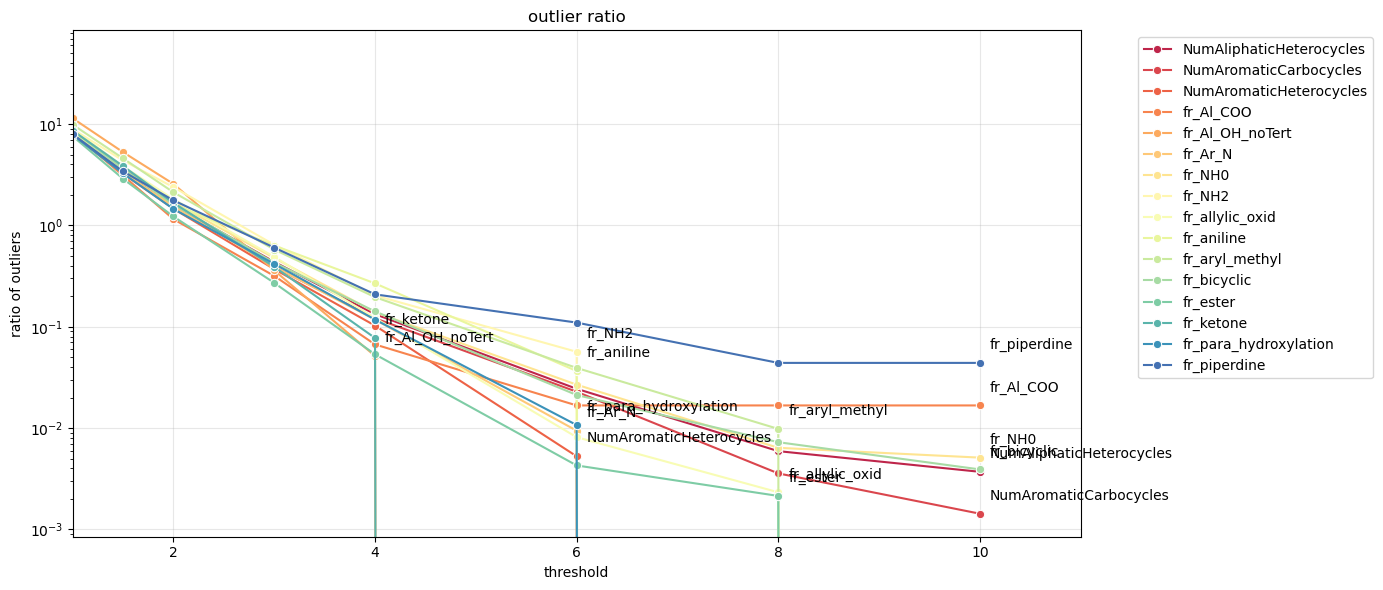

In [27]:
# Call the plotting function
plot_with_connected_lines(iqr_df)

In [28]:
# Set 'IQR' as the index
iqr_df_tot=iqr_df_tot.set_index('threshold')
iqr_df = iqr_df.set_index('threshold')

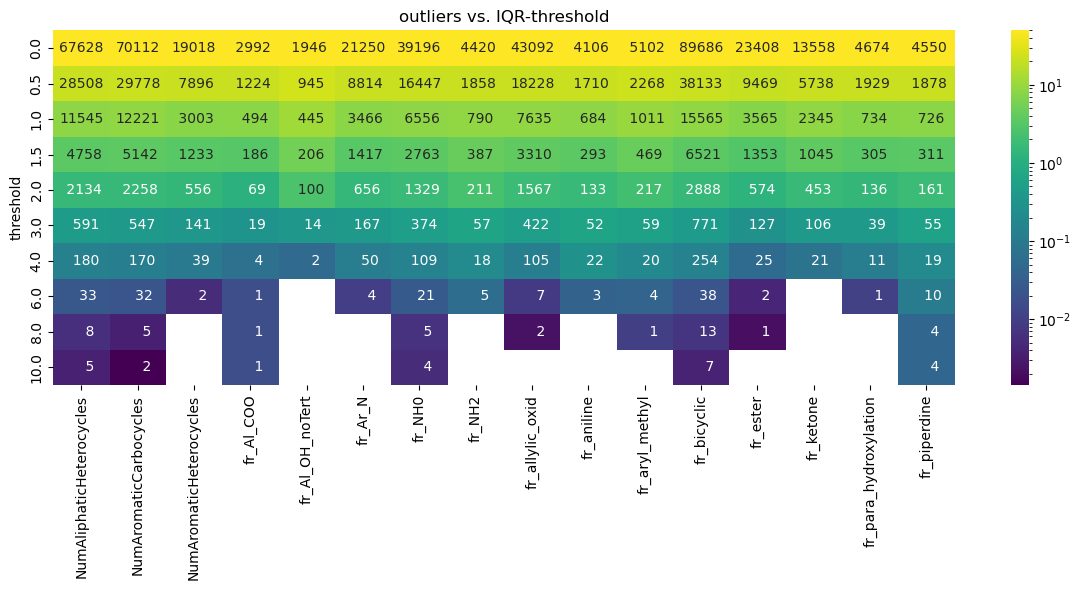

In [29]:
plt.figure(figsize=(12, 6))  # Adjust figure size for better readability

sns.heatmap(iqr_df, annot=iqr_df_tot, cmap="viridis", fmt='5g',norm=LogNorm()) # fmt=".4f" for 4 decimal places #5g

#plt.xlabel("Component")
plt.ylabel("threshold")
plt.title("outliers vs. IQR-threshold")
plt.tight_layout()
plt.savefig("iqr_vs_descriptor_outliers.png")
plt.show()


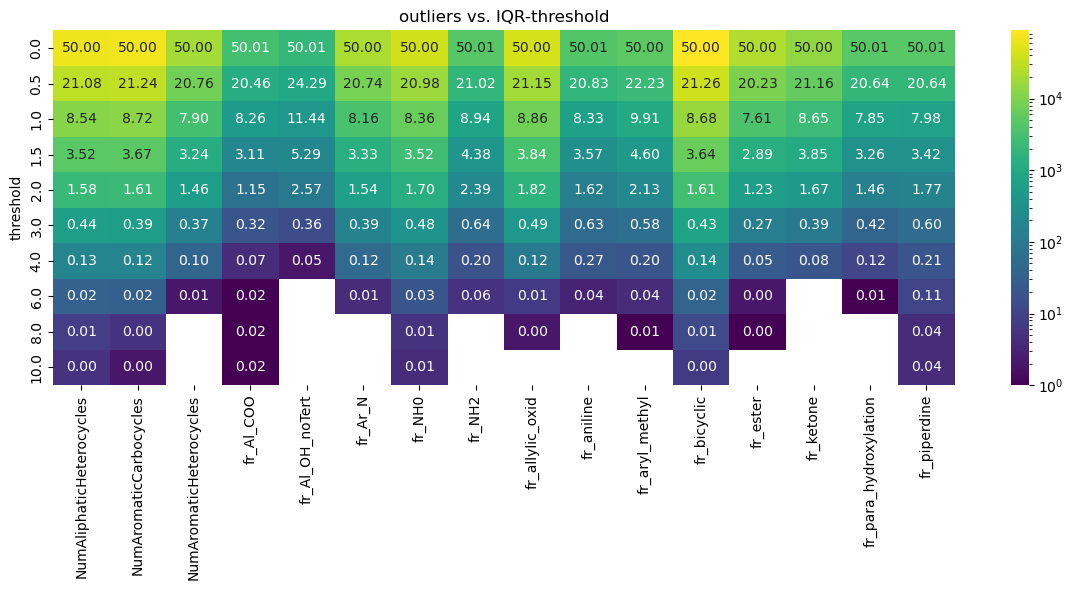

In [30]:
plt.figure(figsize=(12, 6))  # Adjust figure size for better readability

sns.heatmap(iqr_df_tot, annot=iqr_df, cmap="viridis", fmt='.2f',norm=LogNorm()) # fmt=".4f" for 4 decimal places #5g

#plt.xlabel("Component")
plt.ylabel("threshold")
plt.title("outliers vs. IQR-threshold")
plt.tight_layout()
#plt.savefig("iqr_vs_descriptor_outliers.png")
plt.show()

In [31]:
df_concat[(df_concat['diff']>1.0) | (df_concat['diff']<-1.0)]

/home/sat/miniforge3/envs/py310hl_gaps_pub/lib/python3.10/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/home/sat/miniforge3/envs/py310hl_gaps_pub/lib/python3.10/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,GAP,SMILE,GAP_P,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,SPS,MolWt,NumRadicalElectrons,AvgIpc,...,fr_NH2,fr_allylic_oxid,fr_aniline,fr_aryl_methyl,fr_bicyclic,fr_ester,fr_ketone,fr_para_hydroxylation,fr_piperdine,diff
30,3.080078,N=1OC=CC1C2=NOC(=C2)C=3ON=C(C3)C=4ON=C(C4)C5=N...,1.858949,8.614806,0.240128,-0.556503,15.000000,538.392,0,3.980739,...,0,0,0,0,0,0,0,0,0,1.221129
177,1.349609,O=C1C(=O)N(C=2C=CC=CC2)N(C=3C=CC=CC3)C1=O,2.404975,12.495922,0.137664,-1.672572,22.100000,266.256,0,2.925110,...,0,0,2,0,0,0,1,2,0,-1.055366
186,3.400391,O=C(OCC)C(O)(C(=O)OCC)C1C(=O)N(C=2C=CC=CC2)N(C...,2.178531,14.530790,0.477615,-5.021791,27.612903,426.425,0,3.212425,...,0,0,2,0,0,2,0,2,0,1.221860
404,2.650391,N=1N=C2C(OC(=C)N2C1)=C,1.560620,7.349815,0.006481,-0.665926,17.000000,135.126,0,2.660584,...,0,0,0,0,1,0,0,0,0,1.089771
1240,3.380859,ON1N=C2C=CC=CC2=N1,1.768862,7.490741,0.020139,-0.384694,17.000000,135.126,0,2.672015,...,0,0,0,0,1,0,0,0,0,1.611997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405988,1.400391,O=C(OCC)C[NH+]1CC2=CC(OC)=C(OC)C=C2CC1,2.577599,12.803251,1.468867,-4.551410,48.000000,280.344,0,2.728545,...,0,0,0,0,1,1,0,0,0,-1.177208
405998,2.939453,O[C]1[CH][CH][C]([CH][CH]1)[C]2[OH+][C]3[C]([C...,1.841575,10.701694,0.900756,-4.869596,66.076923,722.652,27,0.679516,...,0,0,0,0,2,0,0,0,0,1.097878
406092,1.049805,O=C(NC(C)(C)CC1CC(C)C2CCC(C)C3(CCC(=C)C1C23)[N...,2.091705,14.630150,1.197489,-6.548223,88.757576,459.675,0,3.166600,...,1,1,0,0,0,0,0,0,0,-1.041900
406150,1.549805,O=C1OC2(O)C3=C1C(=O)CCC3(C)C4(C=5NC=6C=CC=CC6C...,2.573359,13.603401,0.179489,-4.556521,61.851852,363.413,0,3.475414,...,0,0,0,0,6,1,1,1,0,-1.023555


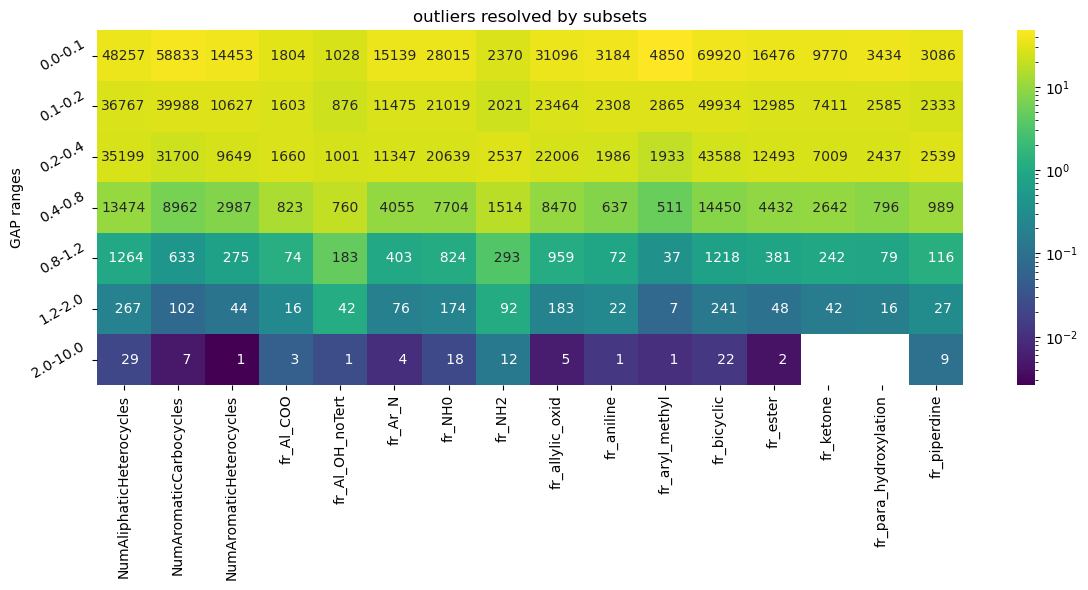

In [32]:
plt.figure(figsize=(12, 6))  # Adjust figure size for better readability

sns.heatmap(percentage_df, annot=count_df, vmin=0,vmax=50,cmap="viridis", fmt='5g',norm=LogNorm()) # fmt=".4f" for 4 decimal places #5g

#plt.xlabel("Component")
plt.ylabel("GAP ranges")
plt.yticks(rotation=30)
plt.title("outliers resolved by subsets")
plt.tight_layout()
plt.savefig("gap_range_vs_descriptor_outliers.png")
plt.show()

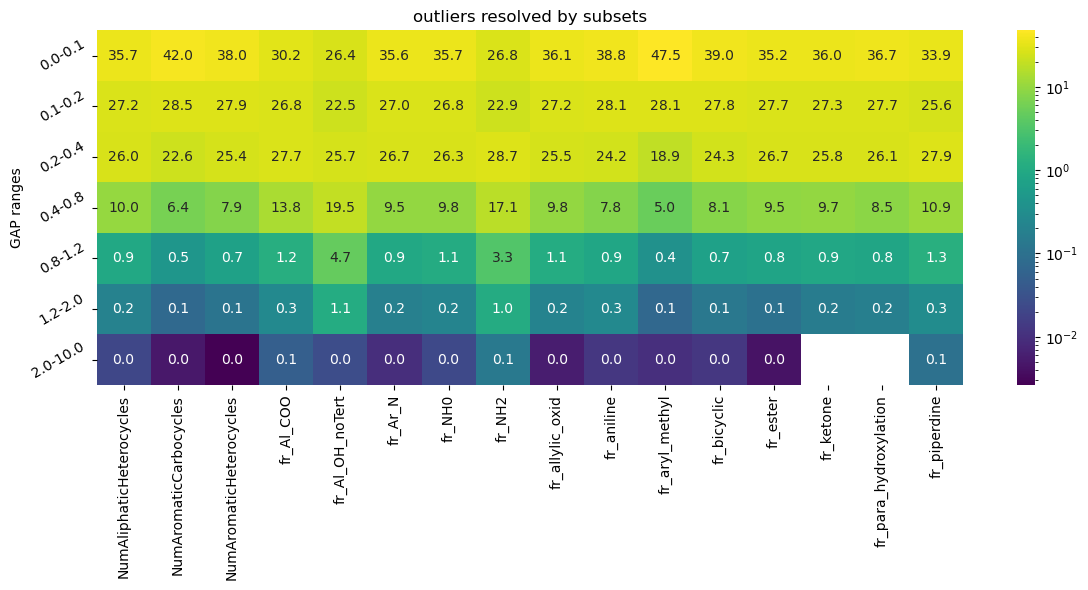

In [33]:
plt.figure(figsize=(12, 6))  # Adjust figure size for better readability

sns.heatmap(percentage_df,  annot=percentage_df,vmin=0,vmax=50,cmap="viridis", fmt='.1f',norm=LogNorm()) # fmt=".4f" for 4 decimal places #5g

#plt.xlabel("Component")
plt.ylabel("GAP ranges")
plt.yticks(rotation=30)
plt.title("outliers resolved by subsets")
plt.tight_layout()
plt.savefig("gap_range_vs_descriptor_outliers_percentage.png")
plt.show()

In [34]:
for ii in range(2,4):
    print("first ",ii)
    for descr in percentage_df.columns:
        sum=percentage_df[descr].iloc[:ii].sum()
        print(descr,"{:.2f}".format(sum))

first  2
NumAliphaticHeterocycles 62.86
NumAromaticCarbocycles 70.47
NumAromaticHeterocycles 65.94
fr_Al_COO 56.94
fr_Al_OH_noTert 48.93
fr_Ar_N 62.62
fr_NH0 62.55
fr_NH2 49.68
fr_allylic_oxid 63.31
fr_aniline 66.89
fr_aryl_methyl 75.61
fr_bicyclic 66.82
fr_ester 62.93
fr_ketone 63.36
fr_para_hydroxylation 64.39
fr_piperdine 59.56
first  3
NumAliphaticHeterocycles 88.88
NumAromaticCarbocycles 93.08
NumAromaticHeterocycles 91.31
fr_Al_COO 84.69
fr_Al_OH_noTert 74.66
fr_Ar_N 89.32
fr_NH0 88.88
fr_NH2 78.38
fr_allylic_oxid 88.84
fr_aniline 91.08
fr_aryl_methyl 94.55
fr_bicyclic 91.12
fr_ester 89.61
fr_ketone 89.21
fr_para_hydroxylation 90.47
fr_piperdine 87.46


### total fragment count vs. diff

In [35]:
frag_list=['fr_Al_COO', 'fr_Al_OH_noTert', 'fr_Ar_N',
       'fr_NH0', 'fr_NH2', 'fr_allylic_oxid', 'fr_aniline', 'fr_aryl_methyl',
       'fr_bicyclic', 'fr_ester', 'fr_ketone', 'fr_para_hydroxylation',
       'fr_piperdine'] #'NumAliphaticHeterocycles', 'NumAromaticCarbocycles','NumAromaticHeterocycles',
base_list=['GAP','SMILE','GAP_P','diff']
df_frag=df_concat[base_list + frag_list].copy()
df_frag['tot_frag']=df_frag[frag_list].sum(axis=1)
df_frag

/home/sat/miniforge3/envs/py310hl_gaps_pub/lib/python3.10/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,GAP,SMILE,GAP_P,diff,fr_Al_COO,fr_Al_OH_noTert,fr_Ar_N,fr_NH0,fr_NH2,fr_allylic_oxid,fr_aniline,fr_aryl_methyl,fr_bicyclic,fr_ester,fr_ketone,fr_para_hydroxylation,fr_piperdine,tot_frag
0,4.218750,CC(=C)C1C2OC(=O)C1C1(O)CC3OC33C(=O)OC2C13C,3.887645,0.331105,0,0,0,0,0,0,0,0,4,2,0,0,0,6
1,1.830078,O=C(O)C=1C(=O)C(O)(CC(=O)C1N)C2OC(COC(=O)C)C(O...,1.460255,0.369824,1,0,0,1,1,2,0,0,0,2,2,0,0,9
2,1.650391,O=C1OC2C(O)C=CC3C4=C5C(=O)C=6C(OC)=CC=C(OC)C6C...,1.858951,-0.208561,0,0,0,0,0,1,0,0,6,1,2,0,0,10
3,1.730469,O=C1OC2C(O)C=CC3C4=C5C(=O)C=6C=CC=C(O)C6C(=O)C...,1.732663,-0.002194,0,0,0,0,0,1,0,0,6,1,2,0,0,10
4,3.580078,O=C(OC1CC(C)(CCOC(=O)C(C)(C)C)C2CC(C)(C)CC2C1O...,3.363940,0.216138,0,0,0,0,0,0,0,0,1,3,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406198,3.970703,O=C(NCCN=C(O)C(F)(F)C(F)(F)C(F)(F)F)C(F)(F)C(F...,3.877003,0.093700,0,1,0,1,0,0,0,0,0,0,0,0,0,2
406199,1.429688,O=C(O)C=CC1=C2NC(C=C3N=C(C=C4NC(=CC5=NC=6C(C(=...,1.545973,-0.116286,1,0,4,2,0,5,0,3,8,1,1,0,0,25
406200,3.130859,O[C]1[CH][C](O)[C]2[CH][C](OC3OC(CO)C(O)C(O)C3...,2.474674,0.656186,0,3,0,0,0,0,0,0,1,0,0,0,0,4
406201,1.839844,O=C(N)C1C(=O)C(N(C)C)C2CC3CC4=C(C(=O)C3C(=O)C2...,1.500383,0.339461,0,0,0,2,1,0,1,0,3,0,4,0,0,11


In [36]:
df_frag['tot_frag'].value_counts().sort_index()

tot_frag
0     15182
1     33978
2     43178
3     43687
4     46160
      ...  
60        2
61        1
69        1
77        1
90        1
Name: count, Length: 61, dtype: int64

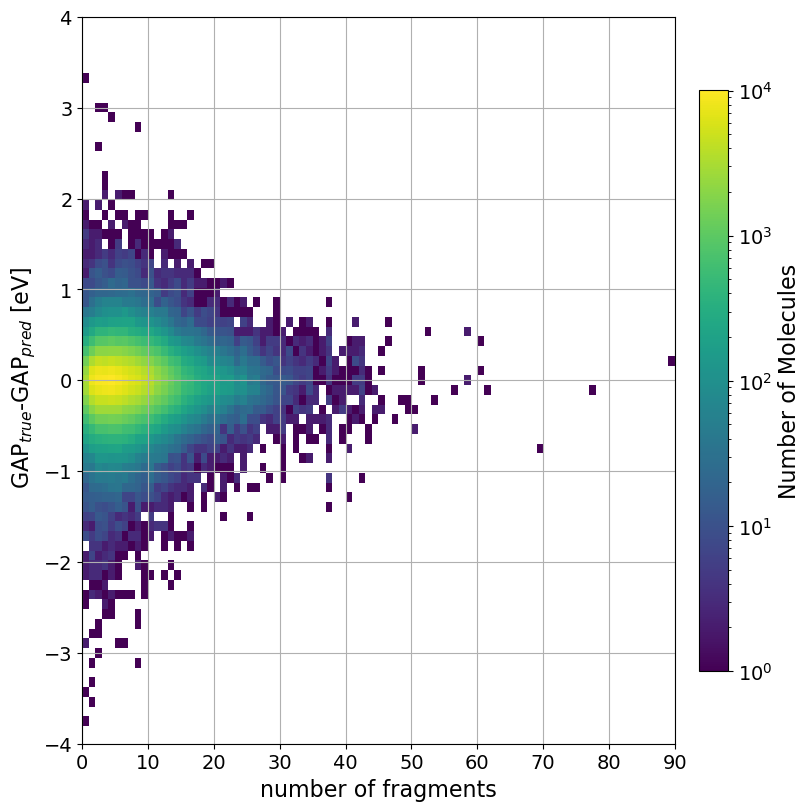

In [37]:
# Define data for the first plot
x1 = df_frag['tot_frag']
y1 = df_frag['diff']
heatmap1, xedges1, yedges1 = np.histogram2d(x1, y1, bins=90, density=False)

# Determine shared color scale
vmin = heatmap1.min()
vmax = heatmap1.max()

# Create a subplot with 2 columns
fig, axs = plt.subplots(1, 1, figsize=(8, 8), constrained_layout=True)

# First subplot: Actual vs. Predicted
im1 = axs.imshow(
    heatmap1.T,
    extent=[xedges1[0], xedges1[-1], yedges1[0], yedges1[-1]],
    origin='lower',
    cmap='viridis',
    aspect='auto',
    norm=LogNorm() #vmin=vmin, vmax=vmax
)
#axs.set_xlim(0, 10)
axs.set_ylim(-4, 4)
axs.grid()
axs.tick_params(axis='both', which='major', labelsize=14)  # Change tick label font size
axs.set_xlabel('number of fragments',fontsize=16)
axs.set_ylabel(' GAP$_{true}$-GAP$_{pred}$ [eV]',fontsize=16)
#axs.set_title('Actual vs. Predicted Values',fontsize=16)



# Add a single colorbar for both plots
cbar = fig.colorbar(im1, ax=axs, orientation='vertical', shrink=0.8, pad=0.02)
cbar.set_label('Number of Molecules',fontsize=16)
cbar.ax.tick_params(labelsize=14)

#plt.savefig("frag_vs_diff.png")
plt.show()

In [38]:
df_frag_04=df_frag[((df_frag['diff'] < -0.8) | (df_frag['diff'] > 0.8 )) & (df_frag['tot_frag'] <20) & (df_frag['tot_frag'] >0) ]
df_frag_04.sort_values(by='diff',inplace=True)

/tmp/ipykernel_20897/3322775055.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_frag_04.sort_values(by='diff',inplace=True)


In [39]:
len(df_frag_04)#/4*80/23

4132

## save images of problematic structures
* uncomment if you need that 

### worst ourliers

In [40]:
outlier_small=df_concat["diff"].nsmallest(4)
outlier_small.index

Index([289832, 2493, 16839, 21820], dtype='int64')

In [41]:
outlier_large=df_concat["diff"].nlargest(4)
outlier_large.values

array([5.84379967, 5.06200563, 4.87732745, 4.77831148])

In [42]:
combined = pd.concat([outlier_small, outlier_large])
combined

289832   -3.800105
2493     -3.580562
16839    -3.454595
21820    -3.330509
125459    5.843800
117130    5.062006
67299     4.877327
127010    4.778311
Name: diff, dtype: float64

In [43]:
combined_df = df_concat.loc[combined.index, ['SMILE', 'diff','GAP','GAP_P']]
combined_df

/home/sat/miniforge3/envs/py310hl_gaps_pub/lib/python3.10/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,SMILE,diff,GAP,GAP_P
289832,O=CC(O)C(O)C(OC1OC(CO)C(OC2OC(CO)C(OC3OC(CO)C(...,-3.800105,2.080078,5.880183
2493,O=NOS(=O)(=O)O,-3.580562,2.199219,5.779781
16839,O=CC(O)C(O)C(O)C[As](=O)(C)C,-3.454595,3.019531,6.474126
21820,O=NC(C)(C)C,-3.330509,1.059570,4.390080
125459,O=C(O)CC(NC(=N)N)C(=O)O,5.843800,9.562500,3.718700
117130,N1CCCC2CC3CC(CN4CCCCC43)(C5NC(CCC5)C6CCC7NC6C8...,5.062006,8.757812,3.695807
67299,N1CCCC2CC3CC(CN4CCCCC43)(C5NC(CCC5)C6CCC7NC6N8...,4.877327,8.406250,3.528923
127010,N1C2N3CCCC4CC5CC(CN6CCCCC65)(C7NC(N8CCCC9CC%10...,4.778311,8.179688,3.401376


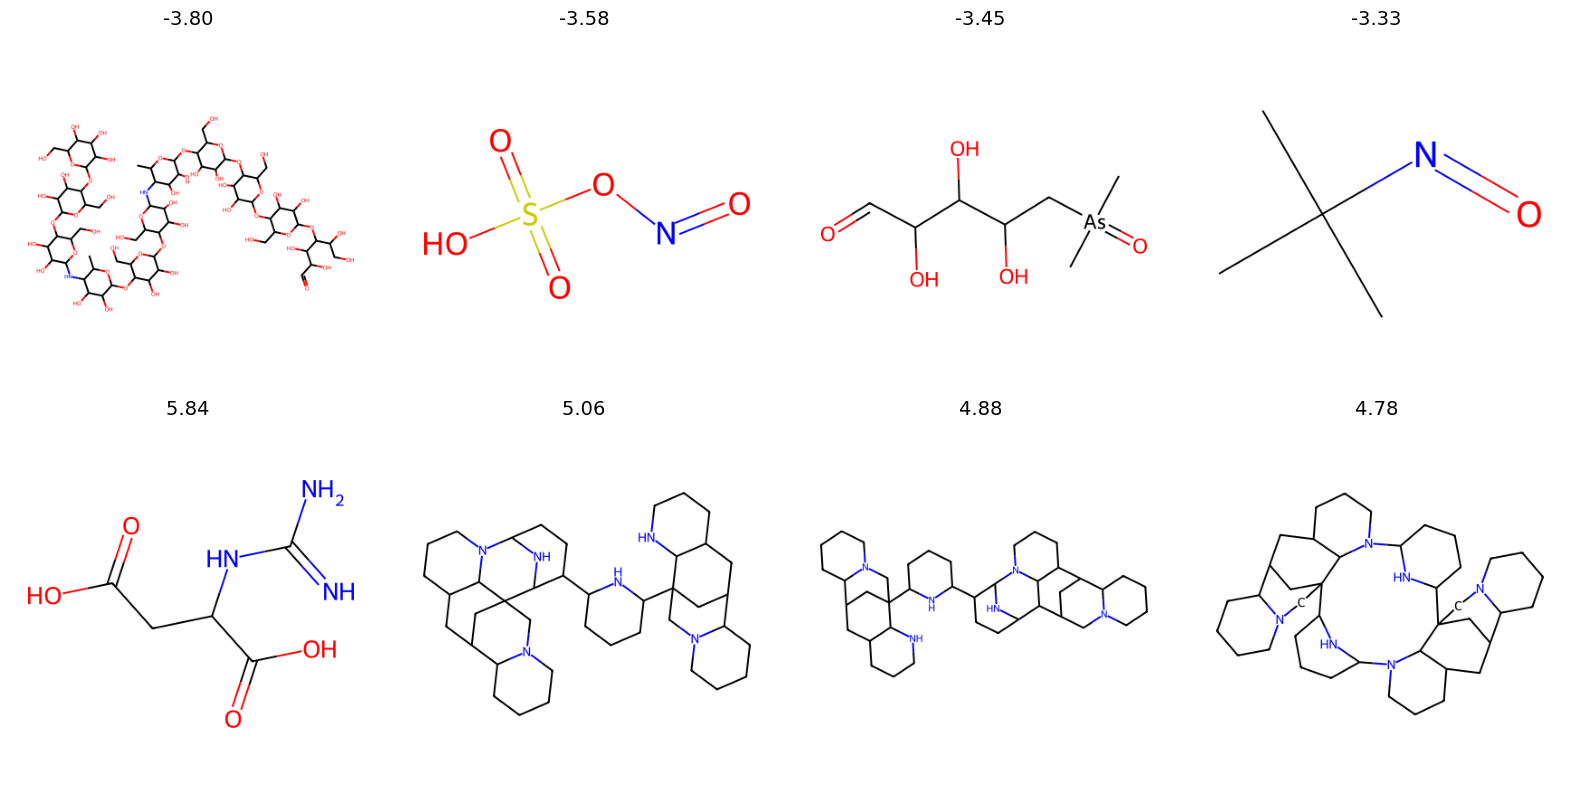

In [44]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
molecules = [Chem.MolFromSmiles(smile) for smile in combined_df['SMILE']]
axes = axes.flatten()
for i, (mol, diff_value) in enumerate(zip(molecules, combined_df["diff"])): #, gap_value,combined_df["GAP"]
    if mol:  # Ensure the molecule is valid
        img = Draw.MolToImage(mol, size=(400, 400))
        axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title(f"{diff_value:.2f} ", fontsize=14) #\n {gap_value:.2f}

# Adjust layout
plt.tight_layout()
plt.show()


### feature permutation

In [48]:
names=X.columns
#print(names)
results_te=load("data/processed/PI_test.joblib")
results_te=pd.DataFrame.from_dict(results_te["importances"].T)
results_te.columns=X.columns
results_te

,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,SPS,MolWt,NumRadicalElectrons,AvgIpc,BalabanJ,HallKierAlpha,Ipc,...,fr_NH0,fr_NH2,fr_allylic_oxid,fr_aniline,fr_aryl_methyl,fr_bicyclic,fr_ester,fr_ketone,fr_para_hydroxylation,fr_piperdine
0,0.142094,0.186979,0.033042,0.051727,0.030449,0.009978,0.030054,0.029194,0.442422,0.021605,...,0.187974,0.033326,0.059698,0.037401,0.004992,0.009793,0.116694,0.124656,0.002631,0.004602
1,0.143283,0.184081,0.031609,0.052090,0.031223,0.009472,0.030332,0.028765,0.443911,0.021332,...,0.192012,0.031878,0.060753,0.037962,0.004354,0.010149,0.120641,0.122940,0.002455,0.004674
2,0.142245,0.184403,0.031409,0.051035,0.029950,0.008518,0.029739,0.029810,0.444630,0.020480,...,0.192447,0.033015,0.056728,0.037355,0.004194,0.010329,0.119707,0.123190,0.002585,0.004939
3,0.143597,0.185967,0.032761,0.052537,0.031857,0.010563,0.031151,0.028947,0.442720,0.021436,...,0.191930,0.032550,0.057547,0.038281,0.004541,0.010114,0.114479,0.125407,0.002598,0.005016
4,0.135368,0.186003,0.032189,0.052769,0.029263,0.009497,0.029645,0.028654,0.438300,0.021876,...,0.189290,0.034083,0.059000,0.038288,0.004308,0.010151,0.119019,0.125122,0.002751,0.004897
5,0.141863,0.185219,0.031747,0.051593,0.029667,0.008937,0.030135,0.028547,0.445203,0.021152,...,0.195007,0.033452,0.062260,0.037726,0.004072,0.010227,0.119535,0.122054,0.002698,0.004975
6,0.138565,0.184848,0.031663,0.051187,0.031151,0.011256,0.029417,0.029458,0.433211,0.020974,...,0.191166,0.032742,0.058321,0.038106,0.004832,0.010109,0.115149,0.124625,0.002859,0.004925
7,0.142339,0.182299,0.031018,0.050797,0.031336,0.009406,0.030366,0.029541,0.441135,0.021375,...,0.193574,0.032209,0.063863,0.037330,0.004359,0.010369,0.121240,0.122478,0.002707,0.005058
8,0.145482,0.185762,0.031627,0.051671,0.030425,0.008363,0.029361,0.028132,0.445844,0.021616,...,0.192030,0.032224,0.062861,0.038106,0.004329,0.010544,0.120336,0.125206,0.002741,0.004577
9,0.139802,0.186830,0.032005,0.050736,0.030087,0.009515,0.030973,0.029273,0.439528,0.021227,...,0.195521,0.033022,0.059530,0.038739,0.004475,0.010326,0.119041,0.122567,0.002718,0.004784


In [49]:
column_means = results_te.mean()
sorted_columns = column_means.sort_values(ascending=False).index

# Reorder the dataframe columns
results_te= results_te[sorted_columns]
results_te

,NumAromaticCarbocycles,SMR_VSA10,SMR_VSA7,HallKierAlpha,fr_NH0,MinAbsEStateIndex,SMR_VSA3,MaxAbsEStateIndex,fr_ketone,fr_ester,...,NumRadicalElectrons,fr_Al_OH_noTert,EState_VSA2,fr_piperdine,EState_VSA5,fr_aryl_methyl,EState_VSA3,EState_VSA4,EState_VSA6,fr_para_hydroxylation
0,0.794330,0.542850,0.534718,0.442422,0.187974,0.186979,0.147776,0.142094,0.124656,0.116694,...,0.009978,0.005993,0.005743,0.004602,0.004392,0.004992,0.004586,0.003019,0.003805,0.002631
1,0.795289,0.540268,0.536643,0.443911,0.192012,0.184081,0.146659,0.143283,0.122940,0.120641,...,0.009472,0.006426,0.005551,0.004674,0.003803,0.004354,0.004440,0.003123,0.002598,0.002455
2,0.812729,0.546195,0.536302,0.444630,0.192447,0.184403,0.149533,0.142245,0.123190,0.119707,...,0.008518,0.006085,0.005306,0.004939,0.004479,0.004194,0.003577,0.003330,0.002381,0.002585
3,0.802763,0.547355,0.543563,0.442720,0.191930,0.185967,0.146156,0.143597,0.125407,0.114479,...,0.010563,0.007614,0.005695,0.005016,0.004177,0.004541,0.003475,0.003545,0.003655,0.002598
4,0.789803,0.539000,0.534467,0.438300,0.189290,0.186003,0.150057,0.135368,0.125122,0.119019,...,0.009497,0.005970,0.005664,0.004897,0.004576,0.004308,0.003456,0.003337,0.002341,0.002751
5,0.794030,0.546090,0.539797,0.445203,0.195007,0.185219,0.151928,0.141863,0.122054,0.119535,...,0.008937,0.005332,0.005517,0.004975,0.004543,0.004072,0.003550,0.003463,0.003305,0.002698
6,0.776005,0.538195,0.532633,0.433211,0.191166,0.184848,0.146542,0.138565,0.124625,0.115149,...,0.011256,0.007190,0.005564,0.004925,0.004654,0.004832,0.002650,0.003425,0.004111,0.002859
7,0.778951,0.544030,0.535803,0.441135,0.193574,0.182299,0.148737,0.142339,0.122478,0.121240,...,0.009406,0.006411,0.005587,0.005058,0.005267,0.004359,0.003603,0.003464,0.003215,0.002707
8,0.792841,0.542052,0.545457,0.445844,0.192030,0.185762,0.150991,0.145482,0.125206,0.120336,...,0.008363,0.005695,0.005672,0.004577,0.004542,0.004329,0.004553,0.003134,0.003476,0.002741
9,0.791817,0.543452,0.542843,0.439528,0.195521,0.186830,0.148243,0.139802,0.122567,0.119041,...,0.009515,0.006695,0.005434,0.004784,0.005289,0.004475,0.003641,0.002965,0.002844,0.002718


/tmp/ipykernel_20897/906368943.py:3: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  ax.boxplot(importances, meanline=True, vert=False, whis=10,widths=0.8, boxprops={"linewidth":0.5},capprops={"linewidth":0.5},meanprops={"linewidth":0.5})


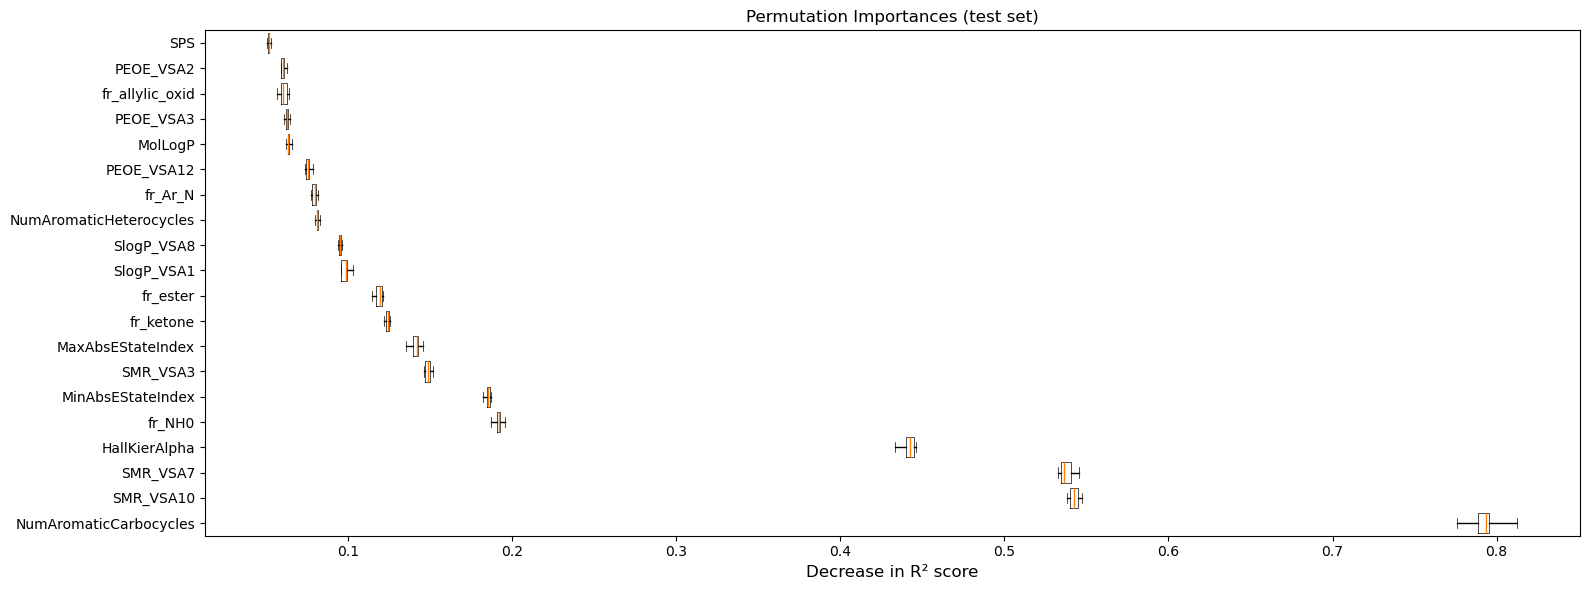

In [50]:
fig, (ax1) = plt.subplots(1, 1, figsize=(16, 6))
for ax, (name, importances) in zip([ax1], [("test", results_te[results_te.columns[:20]])]): #.iloc[:, :10]     #[:,0:10]
    ax.boxplot(importances, meanline=True, vert=False, whis=10,widths=0.8, boxprops={"linewidth":0.5},capprops={"linewidth":0.5},meanprops={"linewidth":0.5})
    ax.set_title(f"Permutation Importances ({name} set)", fontsize=12)
    ax.set_xlabel("Decrease in R² score", fontsize=12)
    #ax.axvline(x=0, color="k", linestyle="--")
    #ax.tick_params(axis='y', labelsize=10)
    #print(importances)
    ax.set_yticklabels(results_te.columns[:20], fontsize=10, rotation=0)
    ax.tick_params(axis='x',labelsize=10)

fig.tight_layout()  # Adjust layout to avoid 
#ax1.yticks(fontsize=12, rotation=45)
plt.savefig("permutation_importance_test.png")

### analyse key features

In [52]:
df_analyse=df_concat[['GAP','GAP_P','NumAromaticCarbocycles','SMR_VSA10','SMR_VSA7','HallKierAlpha']].copy()
df_analyse['diff']=df_analyse['GAP']-df_analyse['GAP_P']
#print(df_analyse[df_analyse['GAP']<6])
df_analyse

/home/sat/miniforge3/envs/py310hl_gaps_pub/lib/python3.10/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,GAP,GAP_P,NumAromaticCarbocycles,SMR_VSA10,SMR_VSA7,HallKierAlpha,diff
0,4.218750,3.887645,0,11.938611,12.104143,-1.40,0.331105
1,1.830078,1.460255,0,47.529786,23.019255,-3.23,0.369824
2,1.650391,1.858951,3,17.535795,92.387300,-4.67,-0.208561
3,1.730469,1.732663,3,17.535795,98.429719,-4.47,-0.002194
4,3.580078,3.363940,2,17.907916,71.551090,-3.15,0.216138
...,...,...,...,...,...,...,...
406198,3.970703,3.877003,0,11.804925,0.000000,-2.04,0.093700
406199,1.429688,1.545973,0,68.133148,87.355408,-5.31,-0.116286
406200,3.130859,2.474674,0,0.000000,92.651910,-0.64,0.656186
406201,1.839844,1.500383,1,34.727546,23.211740,-3.11,0.339461


In [53]:
398003*100/406203

97.98130491404544

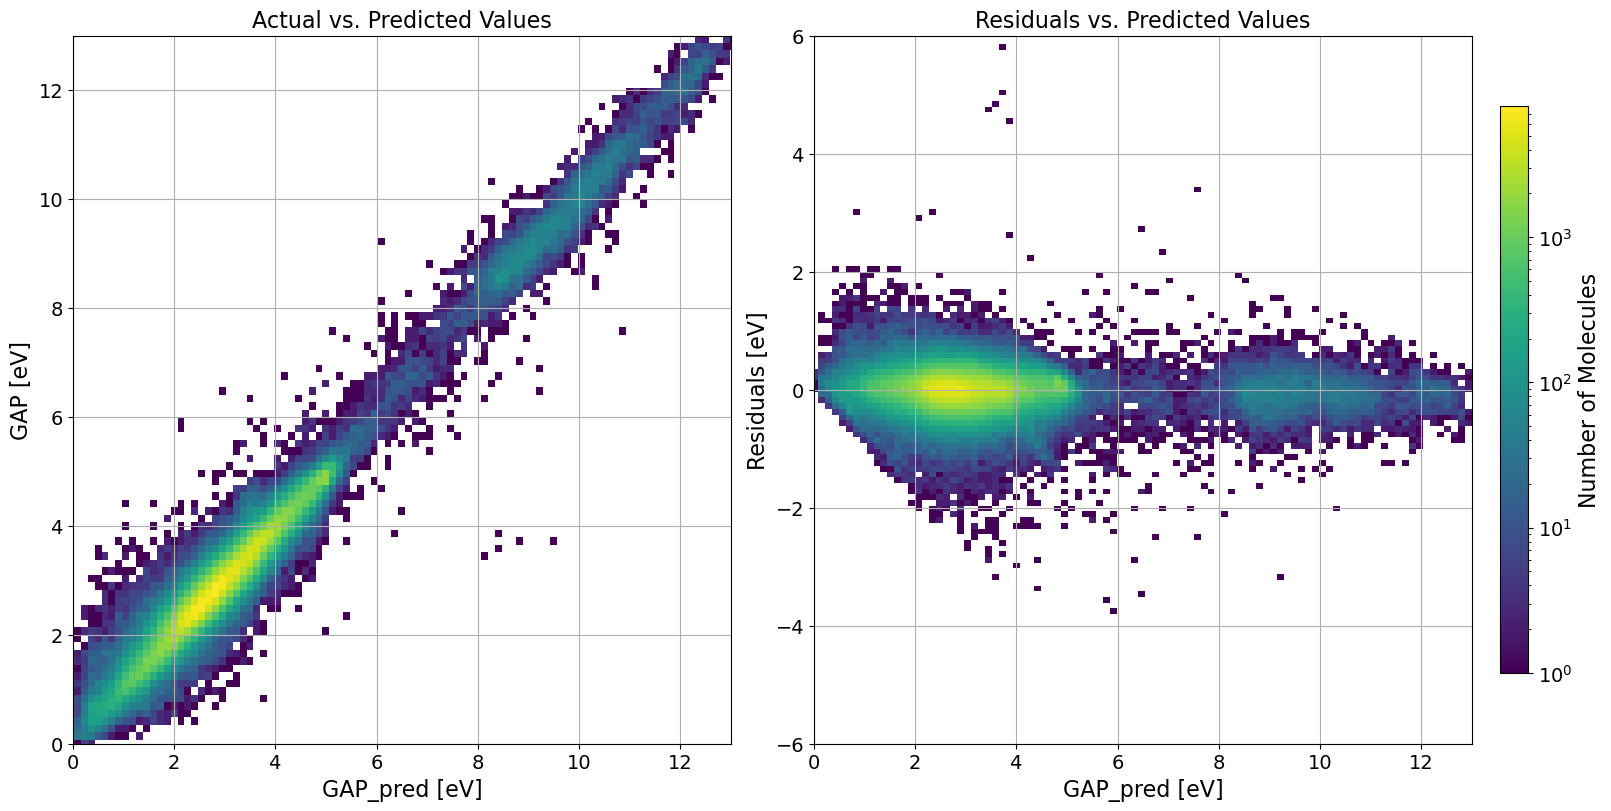

In [54]:
# Define data for the first plot
x1 = df_analyse['GAP']
y1 = df_analyse['GAP_P']
heatmap1, xedges1, yedges1 = np.histogram2d(x1, y1, bins=100, density=False)

# Define data for the second plot
x2 = df_analyse['GAP_P']
y2 = df_analyse['diff']
heatmap2, xedges2, yedges2 = np.histogram2d(x2, y2, bins=100, density=False)

# Determine shared color scale
vmin = min(heatmap1[heatmap1 > 0].min(), heatmap2[heatmap2 > 0].min(), 1e0)
vmax = max(heatmap1.max(), heatmap2.max())

# Create a subplot with 2 columns
fig, axs = plt.subplots(1, 2, figsize=(16, 8), constrained_layout=True)

# First subplot: Actual vs. Predicted
im1 = axs[0].imshow(
    heatmap1.T,
    extent=[xedges1[0], xedges1[-1], yedges1[0], yedges1[-1]],
    origin='lower',
    cmap='viridis',
    aspect='auto',
    norm=LogNorm(vmin=vmin, vmax=vmax)
)
axs[0].set_xlim(0, 13)
axs[0].set_ylim(0, 13)
axs[0].grid()
axs[0].tick_params(axis='both', which='major', labelsize=14)  # Change tick label font size
axs[0].set_xlabel('GAP_pred [eV]',fontsize=16)
axs[0].set_ylabel('GAP [eV]',fontsize=16)
axs[0].set_title('Actual vs. Predicted Values',fontsize=16)

# Second subplot: Residuals vs. Predicted
im2 = axs[1].imshow(
    heatmap2.T,
    extent=[xedges2[0], xedges2[-1], yedges2[0], yedges2[-1]],
    origin='lower',
    cmap='viridis',
    aspect='auto',
    norm=LogNorm(vmin=vmin, vmax=vmax)
)
axs[1].set_xlim(0, 13)
axs[1].set_ylim(-6, 6)
axs[1].grid()
axs[1].tick_params(axis='both', which='major', labelsize=14)  # Change tick label font size
axs[1].set_xlabel('GAP_pred [eV]' ,fontsize=16)
axs[1].set_ylabel('Residuals [eV]',fontsize=16)
axs[1].set_title('Residuals vs. Predicted Values',fontsize=16)

# Add a single colorbar for both plots
cbar = fig.colorbar(im1, ax=axs, orientation='vertical', shrink=0.8, pad=0.02)
cbar.set_label('Number of Molecules',fontsize=16)
cbar.ax.tick_params(labelsize=14)

plt.savefig("PED_heatmap.png")
plt.show()